In [34]:
import cv2
import matplotlib.pyplot as plt
import core.gauge_core as Gauge
import math

In [22]:
img = cv2.imread("./data/clean_gauge1.jpg", cv2.IMREAD_COLOR)
img_copy = img.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

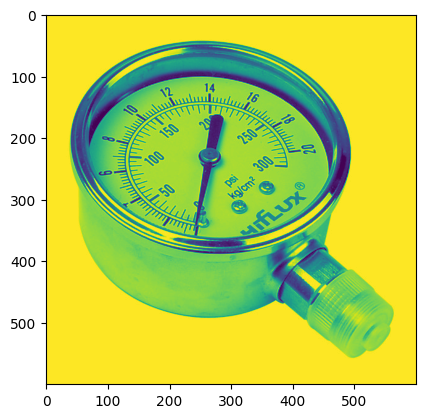

In [3]:
plt.imshow(gray)

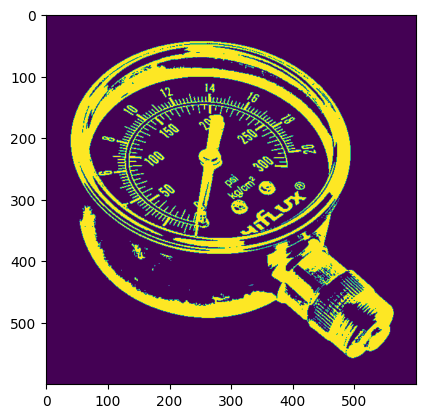

In [4]:
g = Gauge.gauge_cv_adaptiveThreshold(gray)
plt.imshow(g)

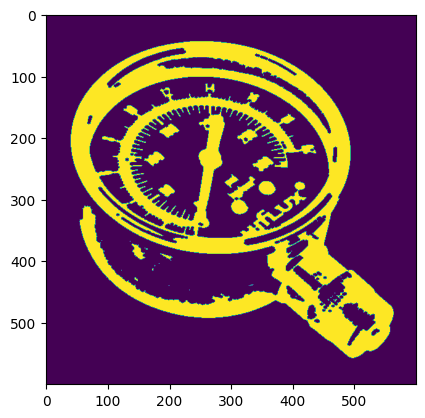

In [5]:
g = Gauge.gauge_cv_morphology(g)
plt.imshow(g)

In [6]:
cnts, hier = Gauge.gauge_cv_findContours(g)

In [9]:
g = Gauge.gauge_cv_drawContours(img, cnts)

In [10]:
best_cnts_index = Gauge.gauge_decision_getTopTenContourIndexes(cnts)

In [11]:
import numpy as np
print(len(best_cnts_index))
print(np.shape(img))

7
(600, 600, 3)


In [12]:
result = []
h = np.shape(img)[0]
w = np.shape(img)[1]
for index in best_cnts_index:
    ellipse = cv2.fitEllipse(cnts[index])
    if(Gauge.gauge_decision_isValidEliipse(h, w, ellipse)):
        result.append(index)

In [13]:
print(result)
best_index = Gauge.gauge_decision_getLongestContourIndex(cnts, result)

[75, 41]


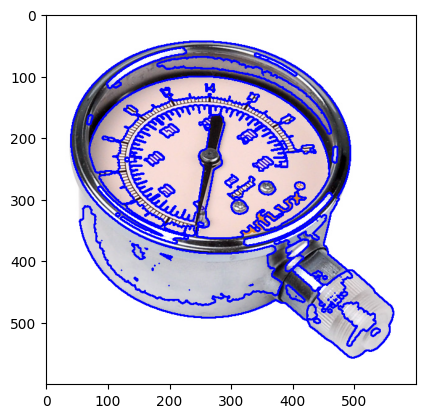

In [14]:
# Gauge.gauge_cv_drawContours(img, cnts[result[0]])
# plt.imshow(img)

In [16]:
print(best_index)
hull = cv2.convexHull(cnts[best_index])

75


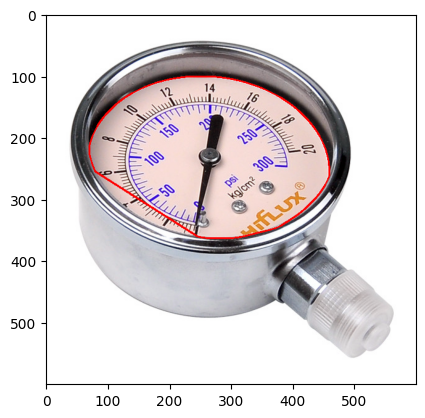

In [18]:
cv2.drawContours(img, [hull], 0, (255, 0, 0), 2)
plt.imshow(img)

((264.45648193359375, 232.27345275878906), (260.4398498535156, 384.9441223144531), 95.76376342773438)


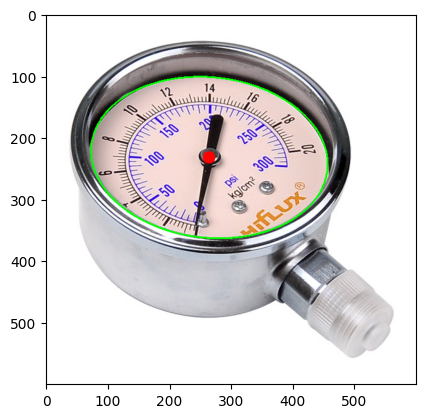

In [77]:
elps = cv2.fitEllipse(cnts[best_index])
elps_hull = cv2.fitEllipse(hull)
print(elps_hull)
cv2.ellipse(img, elps_hull, (0, 255, 0), 2)
cv2.circle(img, (int(elps_hull[0][0]), int(elps_hull[0][1])), 10, (255, 0, 0), -1)
plt.imshow(img)

In [ ]:
# hull을 이용하여 원 또는 타원에 비슷하게 contour 생성이 되었는지 판단한다.

In [33]:
points = hull.reshape(-1, 2)
center = elps_hull[0]

## 타원 유효성 검증 알고리즘

장축 단축을 활용해 convex hull의 유효성 검증

In [74]:
def _distance_2d(src_point, dst_point) -> float:
    return math.sqrt(((src_point[0] - dst_point[0]) ** 2) + ((src_point[1] - dst_point[1]) ** 2))
def _checkVaildationRange(distance_list: list[float], ellipse, accepted_error_ratio=0.05) -> float:
    min_distance = ellipse[1][0] / 2
    max_distance = ellipse[1][1] / 2
    accpeted_error = (max_distance - min_distance) * accepted_error_ratio
    min_distance -= accpeted_error
    max_distance += accpeted_error

    numof_validation_distance = 0
    for distance in distance_list:
        # print(distance, min_distance, max_distance, accpeted_error)
        if ((distance >= min_distance) and (distance <= max_distance)):
            numof_validation_distance += 1
    return numof_validation_distance / len(distance_list)   
def gauge_decision_isValidEllipsePoints(points, ellipse, accepted_error_ratio=0.05):
    """
    해당 포인트들의 집합이 타원형의 형상을 띄는지 검증한다.

    parameter: 
     - points: (n, 2)
     - ellipse: fitEllipse() 출력
     - accepted_error_ratio: 허용되는 픽셀 오차 비율

    return: 
     - distance_distribution_list: 타원 중심으로부터 점 사이의 거리를 계산한 리스트
     - normal_ratio: 타원의 단축 ~ 장축 사이에 존재하는 포인트의 비율
    """
    center = ellipse[0]
    distance_distribution_list = []
    for point in points:
        distance = _distance_2d(center, point)
        distance_distribution_list.append(distance)
    
    normal_ratio = _checkVaildationRange(distance_distribution_list, ellipse)
    return distance_distribution_list, normal_ratio


In [75]:
dist, ratio = gauge_decision_isValidEllipsePoints(points, elps_hull)

## 게이지 영역만 뽑기

bit mask를 통한 게이지 영역 추출

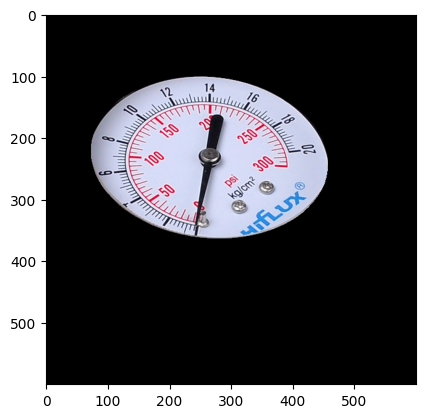

In [76]:
mask = np.zeros_like(img_copy)
mask = cv2.ellipse(mask, elps_hull, (255, 255, 255), -1)
result = np.bitwise_and(img_copy, mask)
result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.imshow(result_rgb)

## 게이지 정렬

뽑힌 게이지 중심 이미지를 정렬한다.

In [78]:
center = elps_hull[0]
center = [c for c in center]
angle = elps_hull[2]
a = elps_hull[1][0]
b = elps_hull[1][1]
center = [center[0]]

[264.45648193359375, 232.27345275878906]


In [86]:
def deg2rad(deg):
    return deg / 360 * 2 * math.pi
def rotate(deg, point):
    """
    point: list[float]
     - point[0]: x coordinate
     - point[1]: y coordinate
    """
    rot_x = math.cos(deg2rad(deg)) * point[0] - math.sin(deg2rad(deg)) * point[1]
    rot_y = -math.sin(deg2rad(deg)) * point[0] - math.cos(deg2rad(deg)) * point[1]
    return rot_x, rot_y

x_axis_point = [elps_hull[1][0]/2, 0]
x1, y1 = rotate(angle, x_axis_point)

y_axis_point = [0, -elps_hull[1][1]/2]
x2, y2 = rotate(angle, y_axis_point)

In [87]:
print(x1, y1)
print(x2, y2)

-13.077605151575058 -129.56158802449875
191.4990037653955 -19.32940462022032


In [ ]:
rectify_img = img_copy.copy()
cv2.circle(rectify_img, ())

## 니들 검출

1. Linear Hough 변환을 사용